In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torchvision.transforms import Resize
import torchvision.transforms as transforms
import torch
import plenoptic as po
import scipy.io as sio
import os
import os.path as op
import einops
import glob
import math
import pyrtools as pt
from tqdm import tqdm
from PIL import Image
%load_ext autoreload
%autoreload 

# We need to download some additional images for this notebook. In order to do so,
# we use an optional dependency, pooch. If the following raises an ImportError or ModuleNotFoundError 
# then install pooch in your plenoptic environment and restart your kernel.
DATA_PATH = po.data.fetch_data('portilla_simoncelli_images.tar.gz')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams['figure.dpi'] = 72

# set seed for reproducibility
po.tools.set_seed(1)

In [2]:
# These variables control how long metamer synthesis runs for. The values present here will result in completed synthesis,
# but you may want to decrease these numbers if you're on a machine with limited resources.
short_synth_max_iter = 1000
long_synth_max_iter = 3000
longest_synth_max_iter = 4000

# Portilla-Simoncelli Texture Metamer

In this tutorial we will aim to replicate [Portilla & Simoncelli (1999)](https://www.cns.nyu.edu/pub/eero/portilla99-reprint.pdf). The tutorial is broken into the following parts:

1. Introduce the concept of a Visual Texture.
2. How to synthesize metamers for the Portilla & Simoncelli texture model. 
3. Demonstrate the importance of different classes of statistics.
4. Extending the model to synthesizing color metamers


Note that this notebook takes a long time to run (roughly an hour with a GPU, several hours without), because of all the metamers that are synthesized.

## 1. What is a visual texture?

The simplest definition is a repeating visual pattern. Textures encompass a wide variety of images, including natural patterns such as bark or fur, artificial ones such as brick, and computer-generated ones such as the Julesz patterns ([Julesz 1978](https://link.springer.com/article/10.1007/BF00336998), [Yellot 1993](https://opg.optica.org/josaa/abstract.cfm?uri=josaa-10-5-777)). Below we load some examples.  

The Portilla-Simoncelli model was developed to measure the statistical properties of visual textures.  Metamer synthesis was used (and can be used) in conjunction with the Portilla-Simoncelli texture model to demonstrate the necessity of different properties of the visual texture.  We will use some of these example textures to demonstrate aspects of the Portilla Simoncelli model.

In [3]:
# For the remainder of the notebook we will use this helper function to
# run synthesis so that the cells are a bit less busy.

# Be sure to run this cell.

def run_synthesis(img, model, loss_function, im_init=None):
    r""" Performs synthesis with the full Portilla-Simoncelli model. 

        Parameters
        ----------
        img : Tensor
            A tensor containing an img.
        model :
            A model to constrain synthesis.
        im_init: Tensor
            A tensor to start image synthesis.

        Returns
        -------
        met: Metamer
            Metamer from the full Portilla-Simoncelli Model

        """
    if im_init is None:
        im_init = torch.rand_like(img) * .01 + img.mean()
    met = po.synth.MetamerCTF(img, model, loss_function=loss_function, initial_image=im_init,
                              coarse_to_fine='together')
    met.synthesize(
        max_iter=long_synth_max_iter, 
        store_progress=True,
        change_scale_criterion=None,
        ctf_iters_to_check=3,
        )
    return met

## 2. Using the Portilla-Simoncelli Model to Compute Realistic Color Metamers

Before adapting the model to synthesize metamers better on color texture images, let's have a look at the existing model's behavior.

### Combining Channel Information in RGB-Images
- The current implementation of the Portilla-Simoncelli Model computes the statistics on all channels separately, i.e., treats each channel as a separate image, resulting in unrealistic metamers (see demo below).
- This is why we will play around with color transforms in the forward method.
- We will first mmic what [Brown 2023](https://dl.acm.org/doi/full/10.1145/3564605#sec-supp) et al. did.
- In particular, we will write our custom Portilla-Simoncelli class, where we do the following steps:

#### Implementation:
0. **Transform to LMS**:
    - transform RGB to an LMS-like space, then from that into opposing color channels (define rgb2opc)
1. **Channel Separation**: The input image is split into its constituent channels.
    - compute L2 loss separately on each channel, the use torch.logsumexp to comine them
2. **Independent Processing**: Each channel is processed independently to compute the relevant statistics.
    - then add cross-channel correlations as in Brown
3. **Normalization and Weighting**: The computed statistics are normalized and weighted to ensure they contribute appropriately to the final representation. E.g., the green channel might be assigned higher weights as it  is often more sensitive in human vision.
4. **Fusion and Integration**: The normalized and weighted statistics are combined to form the final multi-channel representation.

In [4]:
# load a color wheel picture (not a texture!)
file_path = '../src/plenoptic/data/color_wheel.jpg'
#po.imshow(po.tools.load_images(file_path, as_gray=False), as_rgb=True)

In [5]:
# image rescaling if applicable
def adjust_dimensions_for_n_scales(image, n_scales):
        """
        Adjusts the dimensions of an image if they are not divisible by 2^n_scales.
        
        Parameters
        ----------
        image : torch.Tensor
            The input image tensor of shape (C, H, W) or (N, C, H, W).
        n_scales : int
            The number of scales for which the dimensions should be divisible by 2.
        
        Returns
        -------
        torch.Tensor
            The resized image tensor.
        tuple
            A tuple containing the original and adjusted dimensions.
        """
        original_height = image.shape[-2]
        original_width = image.shape[-1]
        
        factor = 2 ** n_scales
        # adjustment calculation:
        # if the dimension is not divisible by 2^n_scales, we adjust it to the next multiple of 2^n_scales
        # e.g. for n_scales = 4, if the dimension is 600, we adjust it to 608
        def adjust_dim(dim):
            return dim if dim % factor == 0 else (dim + (factor - dim % factor))
        
        new_height = adjust_dim(original_height)
        new_width = adjust_dim(original_width)
        
        if (new_height, new_width) != (original_height, original_width):
            resize = Resize((new_height, new_width))
            image = resize(image)
            # let the user know
            print(f"Resized image from ({original_height}, {original_width}) to ({new_height}, {new_width})")
            print('Reason: dimensions must be divisible by 2^n_scales for the model to work')        
        return image

In [6]:
# # Synthesis for color wheel image 
# # run the metamer synthesis on the color image
# img = po.tools.load_images(file_path, as_gray=False).to(DEVICE)
# # Note that the dimensions of the image (height and width) must be divisible by 2 a certain number of times (n_scales).
# # we are using the default values for the PortillaSimoncelli model, so the image must be divisible by 2 four times.
# #synthesis with original PortillaSimoncelli model
# img = adjust_dimensions_for_n_scales(image=img, n_scales=4)
# im_init = (torch.rand_like(img)-.5) * .1 + img.mean() # random initialization for image synthesis
# model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
# metamer = run_synthesis(img, model,loss_function=po.tools.optim.l2_norm, im_init=im_init)

In [7]:
# colorwheel metamer
#po.imshow([metamer.image, metamer.metamer], title=['Target image', 'Synthesized metamer'], as_rgb=True, vrange='auto1')

### Synthesis on Color-Texture Images
#### 1. Synthesis with Original Model

In [8]:
path_to_unsplash = '../../../ceph/Datasets/select_color_textures_unsplash'

In [9]:
# import select color images

# Step 1: Check if the path to the images exists
# You can specify the extensions of the images you want to load, e.g., *.jpg, *.png, etc.
image_files = glob.glob(os.path.join(path_to_unsplash, '*.jpg'))  # Assuming images are in .jpg format
image_files.extend(glob.glob(os.path.join(path_to_unsplash, '*.png')))  # Include .png format as well

# Step 2: Load the images
images = []
for image_file in image_files:
    try:
        img = Image.open(image_file)
        images.append(img)
    except Exception as e:
        print(f"Error loading image {image_file}: {e}")
#po.imshow(po.tools.load_images(path_to_unsplash, as_gray=False), as_rgb=True)


In [10]:
# transform the images to tensors and then resize them to 256x256
#images = [torch.tensor(np.array(img)).permute(2, 0, 1).unsqueeze(0).float() / 255.0 for img in images]
# Define a sequence of transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # resize to 256x256
    transforms.ToTensor(),  # Convert to tensor
])

# Apply the transformations
img_tensor_ls = []
for img in images:
    img_tensor_ls.append(transform(img))

img_tensor = torch.stack(img_tensor_ls, dim=0) # stack the images along the batch dimension
# send images to GPU, if available
img_tensor = img_tensor.to(DEVICE)


# for each image, run synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img_tensor.shape[-2:]).to(DEVICE)
metamers = []
for i in range(img_tensor.shape[0]-4): # only run synthesis for the first, 5 images in the batch
    # metamer = run_synthesis(img_tensor[i:i+1], model)
    metamer = run_synthesis(img_tensor[i:i+1], model,loss_function=po.tools.optim.l2_norm)
    metamers.append(metamer)


/mnt/home/hdettki/code/plenoptic/src/plenoptic/tools/validate.py:178: UserWarning: model is in training mode, you probably want to call eval() to switch to evaluation mode
  warnings.warn(
/mnt/home/hdettki/code/plenoptic/src/plenoptic/tools/validate.py:211: UserWarning: Validating whether model can work with coarse-to-fine synthesis -- this can take a while!
  warnings.warn("Validating whether model can work with coarse-to-fine synthesis -- this can take a while!")


  0%|          | 0/3000 [00:00<?, ?it/s]

/mnt/home/hdettki/code/plenoptic/src/plenoptic/synthesize/metamer.py:661: UserWarning: Loss has converged, stopping synthesis
  warnings.warn("Loss has converged, stopping synthesis")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0008046688..0.9258644].


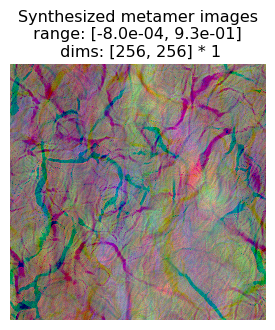

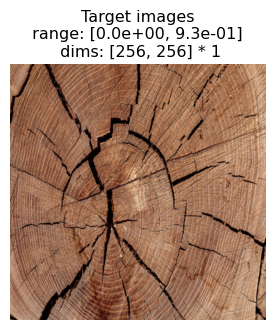

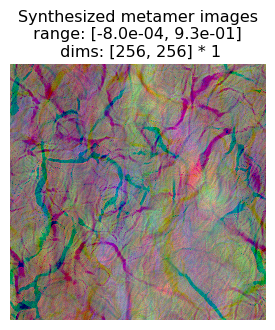

In [11]:
# print the metamer images 
po.imshow([metamer.image for metamer in metamers], title='Target images', as_rgb=True)
# print target image
po.imshow([metamer.metamer for metamer in metamers], title='Synthesized metamer images', as_rgb=True)


Clearly, the above metamers show some discrepancies to the target image, some more, some less. While images 2, 3, and 4 approximate the texture of the target image quite well, the colors are a bit off, especially in image 4. Metamers 1 and 5 are off in both color and texture. It seems that homegeneous, finer patterns are well represented by the model, while distinct coarser structures, such as the arteries in the leaves or the cracks in the wood, are captured, but not in the same location. The result is a combined texture that doesn't reflect the original in the physical world. 

So let's, first tweak the model so that it performs better in terms of color in the metamers.

#### 2. Adapting the Model to Produce Better Color Metamers
**Combining Channel Information in RGB-Images**
- The current implementation of the Portilla-Simoncelli Model computes the statistics on all channels separately, i.e., treats each channel as a separate image, resulting in unrealistic metamers (see demo below).
- This is why we will play around with color transforms in the forward method.
- We will first mmic what [Brown 2023](https://dl.acm.org/doi/full/10.1145/3564605#sec-supp) et al. did.
- In particular, we will write our custom Portilla-Simoncelli class, where we do the following steps:

##### Implementation:
0. **Transform to LMS**:
    - transform RGB to an LMS-like space, then from that into opposing color channels (define rgb2opc)
    - Most of the color transforms are copied from color_utils.py in [PooledStatisticsMetamers](https://github.com/ProgramofComputerGraphics/PooledStatisticsMetamers/blob/main/poolstatmetamer/color_utils.py#L58) repo 
1. **Channel Separation**: The input image is split into its constituent channels.
    - compute L2 loss separately on each channel, the use torch.logsumexp to comine them
2. **Independent Processing**: Each channel is processed independently to compute the relevant statistics.
    - then add cross-channel correlations as in Brown
3. **Normalization and Weighting**: The computed statistics are normalized and weighted to ensure they contribute appropriately to the final representation. E.g., the green channel might be assigned higher weights as it  is often more sensitive in human vision.
4. **Fusion and Integration**: The normalized and weighted statistics are combined to form the final multi-channel representation.

In [12]:
# let's first take care of the transforms
# A approximate transform from a typical RGB space to cone LMS space
# Would be good to check this to see if is a reasonable default approximation for 
# human cone LMS, but results so far don't seem to depend much on precise color transform details
# code largely copied from color_utils in PooledStatisticsMetamers repo 
rgb2lms = torch.tensor([[0.3811, 0.5783, 0.0402],
                        [0.1967, 0.7244, 0.0782],
                        [0.0241, 0.1288, 0.8444]])
lms2rgb = torch.inverse(rgb2lms)
# A simple approximation of the opponent cone color space (achromatic,red-green,blue-yellow)
# I also scaled their magnitudes to make the channels have more simlar ranges
lms2opc = torch.tensor([[0.5, 0.5, 0],    # (L+M) / 2)
                       [-4, 4, 0],        # (M-L) * 3
                       [0.5, 0.5, -1]])  # (L+M)/2 - S)

opc2lms = lms2opc.inverse()

# Composite transform from RGB to cone-opponent color space
rgb2opc = torch.matmul(lms2opc,rgb2lms)

opc2rgb = rgb2opc.inverse()

# Short names for the three opponent channels, short for (achromatic,red-green,blue-yellow)
opc_short_names = ('ac','rg','by')


# Apply the specified color tranformation matrix to an image
def color_transform_image(image,color_matrix):
    if image.dim()==3:
        return torch.nn.functional.conv2d(image[None,:,:,:],color_matrix[:,:,None,None])
    else:
        return torch.nn.functional.conv2d(image,color_matrix[:,:,None,None])

    
# Convert an RGB image to cone LMS image
def rgb_to_coneLMS(image):
    return color_transform_image(image,rgb2lms)

# Convert an RGB image to a cone opponent space image
def rgb_to_opponentcone(image):
    return color_transform_image(image,rgb2opc)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28425252..0.83445024].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.0233624e-10..0.92549026].


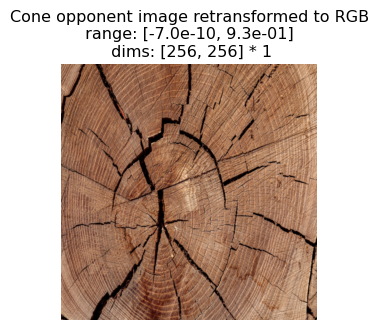

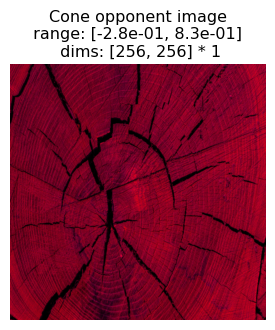

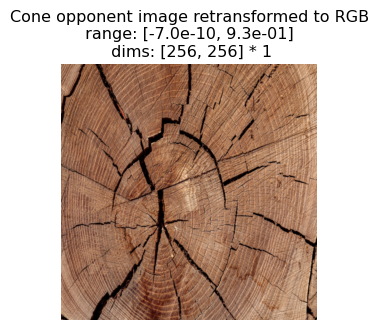

In [13]:
wood_img = img_tensor[0].unsqueeze(dim=0).to('cpu')
opc_image = einops.einsum(wood_img, rgb2opc, 'b c1 h w, c2 c1 -> b c2 h w') # tensor product of image and color matrix
# transform opc image to rgb
opc_image_retransf = einops.einsum(opc_image, opc2rgb, 'b c1 h w, c2 c1 -> b c2 h w')
po.imshow(opc_image, title='Cone opponent image', as_rgb=True)
po.imshow(opc_image_retransf, title='Cone opponent image retransformed to RGB', as_rgb=True)

In [14]:
def rescale(image:torch.Tensor, range:tuple=(0,1)):
    # Scale the input image to the range [0, 1]
    min_val = image.min()
    max_val = image.max()
    print(min_val, max_val) 
    if max_val != min_val:
        print('normalizing. ')
        image = (image - min_val) / (max_val - min_val)
    print(image.min(), image.max())
    return image
# rescale the image to the range [0, 1] on final two dimensions
opc_img_rescaled = rescale(opc_image)
opc_img_rescaled.shape

tensor(-0.2843) tensor(0.8345)
normalizing. 
tensor(0.) tensor(1.)


torch.Size([1, 3, 256, 256])

### custom Loss function
- compute the L2 norm on each channel separately 
- then combine channel losses with logsumexp

In [15]:
def l2_channelwise(synth_rep: torch.Tensor, ref_rep: torch.Tensor, **kwargs) -> torch.Tensor:
    r"""l2-norm of the difference between ref_rep and synth_rep per channel.

    Parameters
    ----------
    synth_rep
        The first tensor to compare, model representation of the
        synthesized image.
    ref_rep
        The second tensor to compare, model representation of the
        reference image. must be same size as ``synth_rep``.
    kwargs
        Ignored, only present to absorb extra arguments.

    Returns
    -------
    loss
        The L2-norm of the difference between ``ref_rep`` and ``synth_rep``.

    """
    channel_losses = torch.linalg.vector_norm(ref_rep - synth_rep, dim=2,ord=2)
    print(f'channel losses {channel_losses}, channel loss shape: {channel_losses.shape}')
    return torch.logsumexp(channel_losses, dim=1) 

In [16]:
#  The following class tweaks the PortillaSimoncelli model so that it will process color images better.
#  In particular, we introduce cross-color channel statistics, to capture the relationship between different color channels.
#  The cross-color statistics are a reduced set of statistis, currently only encompassing covariance/correlation. 
from typing import List, Optional, Any
SCALES_TYPE = Optional[List[int]]

#from collections import OrderedDict
class PortillaSimoncelliCrossChannel(po.simul.PortillaSimoncelli):
    r"""Model for measuring a subset of texture statistics reported by PortillaSimoncelli

    Parameters
    ----------
    im_shape: int
        the size of the images being processed by the model, should be divisible by 2^n_scales
    remove_keys: list
        The dictionary keys for the statistics we will "remove".  In practice we set them to zero.
        Possible keys: ["pixel_statistics", "auto_correlation_magnitude",
        "skew_reconstructed", "kurtosis_reconstructed", "auto_correlation_reconstructed", 
        "std_reconstructed", "magnitude_std", "cross_orientation_correlation_magnitude", 
        "cross_scale_correlation_magnitude" "cross_scale_correlation_real", "var_highpass_residual"]
    """
    def __init__(
        self,
        im_shape,
    ):
        super().__init__(im_shape, n_scales=4, n_orientations=4, spatial_corr_width=9)
        
    def forward(self, image: torch.Tensor, scales: Optional[List[SCALES_TYPE]] = None) -> torch.Tensor:
        """
        Generate Texture Statistics representation of an image with cross-channel statistics.

        Parameters
        ----------
        image : Tensor
            A 4d tensor (batch, channel, height, width) containing the image(s) to analyze.
        scales : List[SCALES_TYPE], optional
            Which scales to include in the returned representation. If None, include all scales.

        Returns
        -------
        representation_tensor : Tensor
            3d tensor of shape (batch, channel, stats) containing the measured texture statistics.

        Raises
        ------
        ValueError
            If `image` is not 4d or has a dtype other than float or complex.
        """
        # Scale the input image to the range [0, 1]
        min_val = image.min()
        max_val = image.max()
        # print(min_val, max_val) 
        if max_val != min_val:
            # print('normalizing. ')
            image = (image - min_val) / (max_val - min_val)

        # modify operations  based on scales argument
        if scales is None:
            scales = self.scales

        # call the parent class forward method to compute the base statistics
        base_representations = super().forward(image)

        # compute the cross-channel statistics
        cross_channel_stats = self._compute_cross_channel_stats(image)

        # modidfy the base representation to include the cross-channel statistics
        representation_tensor = torch.cat((base_representations, cross_channel_stats), dim=-1)

        # unnormalize representation_tensor
        representation_tensor = representation_tensor * (max_val - min_val) + min_val

        return representation_tensor

    def _compute_cross_channel_stats(self, image:torch.Tensor) -> torch.Tensor:
        """
        Compute cross-channel statistics for the input image.

        Parameters
        ----------
        image : torch.Tensor
            A 4d tensor (batch, channel, height, width) containing the image(s) to analyze.

        Returns
        -------
        torch.Tensor
            3d tensor of shape (batch, channel, stats) containing the cross-channel statistics.
        """


        # Example statistics to compute:

        ## Compute mean across channels
        ## Compute correlation
        ## compute the cross-channel statistics
        cross_channel_stats = self._compute_cross_channel_covariance(image)



        return cross_channel_stats
    
    def _compute_cross_channel_covariance(self, lms_image:torch.Tensor) -> torch.Tensor:
        """
        Compute the cross-channel covariance for the input image.

        Parameters
        ----------
        lms_image : torch.Tensor
            A 4d tensor (batch, channel, height, width) containing the image(s) in cone LMS space.

        Returns
        -------
        torch.Tensor
            3d tensor of shape (batch, channel, stats) containing the cross-channel covariance statistics.
        """
        batch_size, num_channels, height, width = lms_image.shape
        # compute the mean across the channel dimension
        
        mean_across_channels = lms_image.mean(dim=(2,3), keepdim=True) #  shape: [batch_size, num_channels, 1, 1]
        #mean_across_channels = reduce(lms_image, 'b c h w -> b c 1 1', 'mean')

        # Initialize covariance matrix
        covariance_matrix = torch.zeros(batch_size, num_channels, num_channels, device=lms_image.device)

        
        # compute the covariance matrix
        #Cov_ij​=E[(lms_image:,i,:,:​−μi​)(lms_image:,j,:,:​−μ_j​)],
        # where μ_i​ is the mean of the i-th channel across the spatial dimensions (height and width)
        # and lms_image[]:,i,:,:​] is the i-th channel of the image μ_i
        for i in range(num_channels): # for each channel
            for j in range(num_channels): 
                covariance_matrix[:, i, j] = ((lms_image[:, i, :, :] - mean_across_channels[:, i, :, :]) *
                                            (lms_image[:, j, :, :] - mean_across_channels[:, j, :, :])).mean(dim=(1, 2))

        return covariance_matrix



    
    # def remove_scales(self, representation_tensor: torch.Tensor, scales: List[SCALES_TYPE]) -> torch.Tensor:
    #     """
    #     Remove scales from the representation tensor based on the provided scales list.
        
    #     Parameters
    #     ----------
    #     representation_tensor : Tensor
    #         The original representation tensor.
    #     scales : List[SCALES_TYPE]
    #         The scales to include in the returned representation.
        
    #     Returns
    #     -------
    #     representation_tensor : Tensor
    #         The representation tensor filtered by the specified scales.
    #     """
    #     # Logic to filter the representation tensor based on the scales
    #     # Assuming self.scales contains the list of all possible scales
    #     all_scales = self.scales
    #     scale_indices = [all_scales.index(scale) for scale in scales if scale in all_scales]

    #     # Filtering the representation tensor
    #     # The exact slicing logic will depend on the structure of representation_tensor and how scales are represented in it
    #     representation_tensor = representation_tensor[..., scale_indices]

    #     return representation_tensor



In [17]:
# run the metamer synthesis on the opc image
img = opc_img_rescaled.to(DEVICE)
#synthesis with cross-channel PortillaSimoncelli model
model = PortillaSimoncelliCrossChannel(img.shape[-2:]).to(DEVICE)
model.eval()
metamer = run_synthesis(img, model, loss_function=l2_channelwise)


  0%|          | 0/3000 [00:00<?, ?it/s]

channel losses tensor([[21.7509, 20.1691, 17.4902]], device='cuda:0'), channel loss shape: torch.Size([1, 3])
channel losses tensor([[21.7509, 20.1691, 17.4902]], device='cuda:0',
       grad_fn=<LinalgVectorNormBackward0>), channel loss shape: torch.Size([1, 3])
channel losses tensor([[20.2713, 19.9564, 17.1883]], device='cuda:0'), channel loss shape: torch.Size([1, 3])
channel losses tensor([[20.2713, 19.9564, 17.1883]], device='cuda:0',
       grad_fn=<LinalgVectorNormBackward0>), channel loss shape: torch.Size([1, 3])
channel losses tensor([[18.8102, 19.8084, 16.9725]], device='cuda:0'), channel loss shape: torch.Size([1, 3])
channel losses tensor([[18.8102, 19.8084, 16.9725]], device='cuda:0',
       grad_fn=<LinalgVectorNormBackward0>), channel loss shape: torch.Size([1, 3])
channel losses tensor([[17.5179, 19.6889, 16.8111]], device='cuda:0'), channel loss shape: torch.Size([1, 3])
channel losses tensor([[17.5179, 19.6889, 16.8111]], device='cuda:0',
       grad_fn=<LinalgVector

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00023724147..1.0024978].


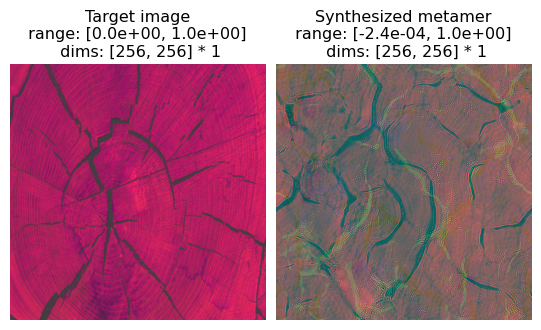

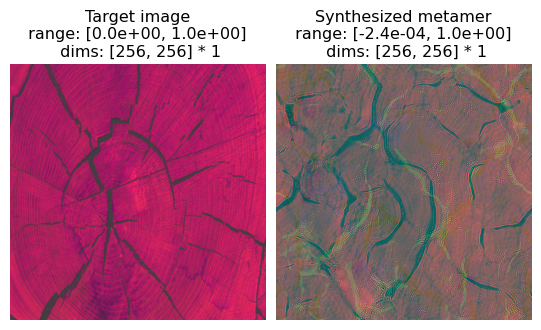

In [18]:
po.imshow([metamer.image, metamer.metamer], title=['Target image', 'Synthesized metamer'], as_rgb=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.061621826..1.1321576].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.60635215..1.2363782].


torch.Size([1, 3, 256, 256])


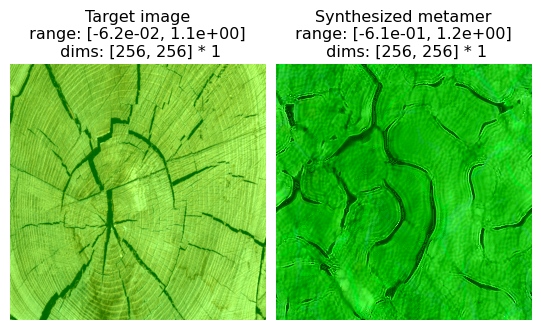

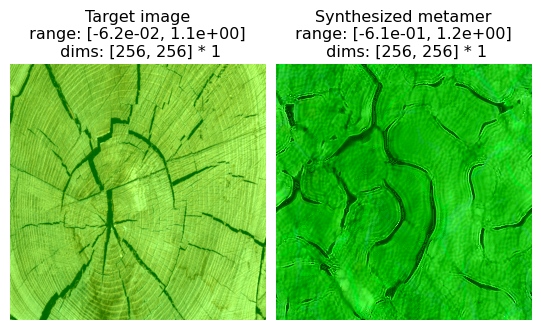

In [19]:
# transform images back to RGB space
print(metamer.metamer.shape)
opc_metamer_retransf = einops.einsum(metamer.metamer, opc2rgb.to(DEVICE), 'b c1 h w, c2 c1 -> b c2 h w')
opc_target_retransf = einops.einsum(metamer.image, opc2rgb.to(DEVICE), 'b c1 h w, c2 c1 -> b c2 h w')

#opc2rgb_metamer = color_transform_image(metamer.metamer, opc2rgb.to(DEVICE))
#opc2rgb_target = color_transform_image(metamer.image, opc2rgb.to(DEVICE))
po.imshow([opc_target_retransf, opc_metamer_retransf], title=['Target image', 'Synthesized metamer'], as_rgb=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00023724147..1.0024978].


/mnt/home/hdettki/code/plenoptic/src/plenoptic/tools/display.py:950: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


ValueError: representation tensor is the wrong length (expected 1046 but got 1049)! Did you remove some of the scales? (i.e., by setting scales in the forward pass)? convert_to_dict does not support such tensors.

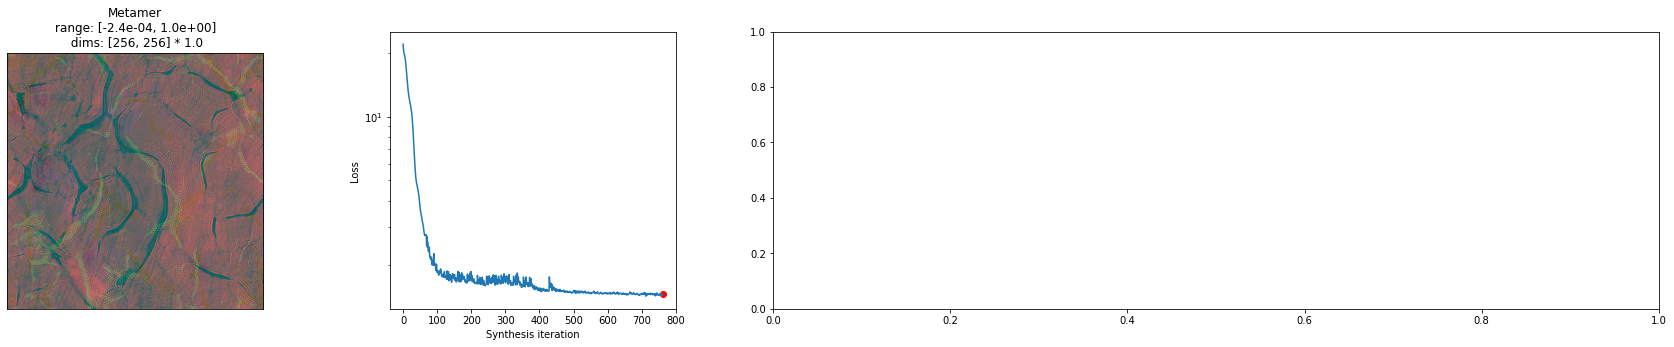

In [20]:
po.synth.metamer.plot_synthesis_status(metamer, width_ratios={'plot_representation_error': 3.1});

In [ ]:
# create a tensor of shape 1, 3, 1049
test_tensor = torch.rand(1, 3, 1049)
l2_channelwise = torch.linalg.vector_norm(test_tensor, dim=2, ord=2)

In [ ]:
# print first dim of test_tensor
print(test_tensor[0, :, :].shape)


torch.Size([3, 1049])


In [ ]:
l2_channelwise

tensor([[18.3352, 18.8565, 19.0799]])